In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error, make_scorer
from sklearn.linear_model import RidgeCV
from tensorflow.keras.preprocessing.sequence import pad_sequences
warnings.resetwarnings()

## Baseline comparisons.

Because I am predicting the number of new cases per million on a daily basis, (i.e. not the rate) I am going to employ a naive (constant) baseline.


## Metric to determine model accuracy

I will be using mean absolute error as to minimize the effect of outliers.


## Details yet to be incorporated:

Growth of standard deviation over time in forecasting.
To accomplish this, I will produce a number of "new" features which attempt to capture the time dependence via rolling averages and rolling standard deviations. I will also one-hot encode certain variables which represent flags for certain behaviors or discrete, time independent variables such as location (country).

# Modeling the number of cases of COVID-19


# Table of contents<a id='toc'></a>

## [COVID-19 Case number modeling ](#model)


In [2]:
def country_slice(data, locations):
    if type(locations)==str:
        return data[data.location==locations]
    else:
        return data[data.location.isin(locations)]
    
def time_slice(data, start, end, indexer='time_index'):
    if start < 0 and end < 0:
        if start == -1:
            start = data.loc[:, indexer].max()
        else:
            start = data.loc[:, indexer].max()+start
        if end == -1:
            end = data.loc[:, indexer].max()
        else:
            end = data.loc[:, indexer].max()+end
    return data[(data.loc[:, indexer] >= start) & (data.loc[:, indexer] <= end)]

def per_country_plot(data, feature, legend=True):
    data.set_index(['time_index', 'location']).loc[:, feature].unstack().plot(legend=legend)
    return None

def per_time_plot(data, feature, legend=True):
    data.set_index(['location','time_index']).loc[:, feature].unstack().plot(legend=legend)
    return None

def country_groupby(df):
    return [df[df.location==country].index for country in df.location.unique()]

def country_search(df, country):
    return df[df.location==country].index

def column_search(df, name, return_style='loc', threshold='contains'):
    if threshold=='contains':
        func = df.columns.str.contains
    else:
        func = df.columns.str.match
        
    if return_style == 'loc':
        return df.columns[func(name)]
    elif return_style== 'iloc':
        return np.where(func(name))[0]
    else:
        return None


def concatenate_4d_into_3d(splits, train_test_only=False):
    
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_test, y_test) 
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
        X_train = np.concatenate(X_train, axis=0)
        y_train = np.concatenate(y_train, axis=0)
        X_validate = np.concatenate(X_validate, axis=0)
        y_validate = np.concatenate(y_validate, axis=0)
        X_test = np.concatenate(X_test, axis=0)
        y_test = np.concatenate(y_test, axis=0)
        concat_splits = (X_train, y_train, X_validate, y_validate, X_test, y_test) 
    return concat_splits

def transpose_for_separable2d(splits, train_test_only=False):
    if train_test_only:
        (X_train, y_train, X_test, y_test) = splits
        X_train = np.transpose(X_train, axes=[0,2,1,3])
        X_test = np.transpose(X_test, axes=[0,2,1,3])
        transpose_split = (X_train, y_train, X_test, y_test) 
    else:
        (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
        X_train = np.transpose(X_train, axes=[0,2,1,3])
        X_validate = np.transpose(X_validate, axes=[0,2,1,3])
        X_test = np.transpose(X_test, axes=[0,2,1,3])
        transpose_split = (X_train, y_train, X_validate, y_validate, X_test, y_test) 
    return transpose_split

    
def true_predict_plot(y_true, y_naive, y_predict, title='', suptitle='', scale=None,s=None):
    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(20,5))
    if scale == 'log':
        ymax = np.max([np.log(1+y_true).max(), np.log(1+y_predict).max()])
        ax1.scatter(np.log(y_true+1), np.log(y_naive+1), s=s,alpha=0.7)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(np.log(y_true+1), np.log(y_predict+1), s=s,alpha=0.7)
        ax2.plot([0, ymax], [0, ymax],color='r')
    else:
        ymax = np.max([y_true.max(), y_predict.max()])
        ax1.scatter(y_true, y_naive, s=s)
        ax1.plot([0, ymax], [0, ymax],color='r')
        ax2.scatter(y_true, y_predict, s=s)
        ax2.plot([0, ymax], [0, ymax],color='r')
    ax1.set_xlabel('True value')
    ax1.set_ylabel('Predicted value')
    ax1.set_title('Naive model')

    ax2.set_xlabel('True value')
    ax2.set_ylabel('Predicted value')
    ax2.set_title(title)
    ax1.grid(True)
    ax2.grid(True)
    plt.suptitle(suptitle)
    plt.show()
    return None

def residual_plot(y_test, y_predict, title='', ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.scatter(y_test, y_test-y_predict.ravel(), s=5)
    ax.set_ylabel('Residual')
    ax.set_xlabel('True value')
    ax.grid(True)
    return None

def residual_diff_plots(y_true, y_naive, y_predict,n_days_into_future, n_countries, scale=None):
    fig, axes = plt.subplots(2, 2, figsize=(20,5), sharey=True)
    (ax1,ax2,ax3,ax4) = axes.flatten()
    xrange = range(len(y_true))
    if scale=='log':
        ax1.plot(xrange, np.log(y_true+1)
             -np.log(y_naive+1))
        ax2.plot(xrange, np.log(y_true+1)
                 -np.log(y_predict+1))
        residual_plot(np.log(y_true+1),np.log(y_naive+1), ax=ax3)
        residual_plot(np.log(y_true+1),np.log(y_predict+1), ax=ax4)
    else:
        ax1.plot(xrange, y_true-y_naive)
        ax2.plot(xrange, y_true-y_predict)
        residual_plot(y_true,y_naive, ax=ax3)
        residual_plot(y_true,y_predict, ax=ax4)
    fig.suptitle('{}-day-into-future predictions'.format(n_days_into_future))
    ax1.set_title('Country-wise differences')
    ax2.set_title('Country-wise differences')
    ax1.set_ylabel('True - Naive')
    ax2.set_ylabel('True - CNN')
    ax1.grid(True)
    ax2.grid(True)
    plt.show()
    return None



def create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries):
    for max_date_in_window in range(start_date, time_index.max() - n_days_into_future + 2):
        # Take all model_data with date proxy less than numerical value, leading_window_date_not_included
        frame_data = model_data[(time_index <= max_date_in_window-1) & 
                                (time_index >= max_date_in_window-frame_size)]
        #     print(frame_data.shape)
        # Reshape the array such that each element along axis=0 is a time series of all feature model_data of a specific country.
        reshaped_frame_data = frame_data.values.reshape(n_countries, frame_size, -1)
#         print(reshaped_frame_data.shape)
        #     print(reshaped_frame_data.shape)
        # Truncate / pad the windows along the "time" axis, axis=1. (pad_sequences takes in an iterable of iterables;
        # the first axis is always the default iteration axis. 
        # *********************** WARNING: pad_sequences converts to integers by default *********************
        resized_frame_data = pad_sequences(reshaped_frame_data, maxlen=frame_size, dtype=np.float64)
        frame_data_4D = resized_frame_data[np.newaxis, :, :, :]
        if max_date_in_window == start_date:
            print('Starting with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)
            X = frame_data_4D.copy()
        else:
            X = np.concatenate((X, frame_data_4D),axis=0)
    print('Ending with frame ranging time_index values:', max_date_in_window-frame_size, max_date_in_window - 1)
    y = target_data.values.reshape(-1, time_index.nunique()).transpose()[-X.shape[0]:,:]
    return X, y

def split_Xy(X, y, frame_size, n_validation_frames, n_test_frames, train_test_only=False, model_type='cnn'):
    """ Split into training, validation and test data.
    """
    
    # the indices for the train-validate-test splits for when the predictors are put in a 2-d format.
    train_indices = list(range(n_countries*0, n_countries*(len(X)-(n_validation_frames+n_test_frames))))
    validate_indices = list(range(n_countries*(len(X)-(n_validation_frames+n_test_frames)), n_countries*(len(X)-n_test_frames)))
    test_indices = list(range(n_countries*(len(X)-n_test_frames), n_countries*len(X)))
    indices = (train_indices, validate_indices, test_indices)

    # Note that the last frame (date_range) that exists in X has already been determined by the choice of the number
    # of steps to predict in the future, this is only slicing the frames. 
    if train_test_only:
        X_train= X[:-n_test_frames,:,:,:]
        y_train =  y[:-n_test_frames,:]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_test, y_test)
    else:
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_train= X[:-(n_validation_frames+n_test_frames),:,:,:]
        y_train =  y[:-(n_validation_frames+n_test_frames),:]
        X_validate = X[-(n_validation_frames+n_test_frames):-n_test_frames, :, :, :]
        y_validate = y[-(n_validation_frames+n_test_frames):-n_test_frames, :]
        X_test = X[-n_test_frames:, :, :, :] 
        y_test = y[-n_test_frames:, :]
        splits =  (X_train, y_train, X_validate, y_validate,
                   X_test, y_test)

    return splits, indices


def flatten_Xy(splits):
    (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
    X_train_flat =np.concatenate(X_train.reshape(X_train.shape[0], X_train.shape[1], -1), axis=0)
    X_validate_flat =np.concatenate(X_validate.reshape(X_validate.shape[0], X_validate.shape[1], -1), axis=0)
    X_test_flat =np.concatenate(X_test.reshape(X_test.shape[0], X_test.shape[1], -1), axis=0)
    y_train_flat = y_train.ravel()
    y_validate_flat = y_validate.ravel()
    y_test_flat = y_test.ravel()
    flat_splits = (X_train_flat , y_train_flat , X_validate_flat , y_validate_flat , X_test_flat , y_test_flat)
    return flat_splits

def model_analysis(y_true, y_naive, y_predict,n_countries, title='',suptitle=''):
    print('There were {} negative predictions'.format(len(y_predict[y_predict<0])))
    #     y_predict[y_predict<0]=0
    mse_train_naive = mean_squared_error(y_true.ravel(), y_naive.ravel())
    mse_predict = mean_squared_error(y_true.ravel(), y_predict)
    r2_train_naive = explained_variance_score(y_true.ravel(), y_naive.ravel())
    r2_predict = explained_variance_score(y_true.ravel(), y_predict)

    print('{}-step MSE [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, mse_train_naive, mse_predict))
    print('{}-step R^2 [Naive, {}] = [{},{}]'.format(
    n_days_into_future,title, r2_train_naive, r2_predict))

    true_predict_plot(y_true.ravel(), y_naive.ravel(), y_predict, title=title, suptitle=suptitle)
    residual_diff_plots(y_true.ravel(), y_naive.ravel(), y_predict , n_days_into_future, n_countries)
    return None


def normalize_Xy(splits, feature_range=(0., 1.0), normalization_method='minmax',
                        train_test_only=False, feature_indices=None):
    """ Split into training, validation and test data.
    Normalize with respect to some absolute max, just choose 2*absolute max of training set. 

    """
    
    min_, max_ = feature_range
    (X_train, y_train, X_validate, y_validate, X_test, y_test) = splits
    feature_minima = X_train[:,:,:,:].min((0,1,2))[np.newaxis,np.newaxis,np.newaxis,:]
    feature_maxima = 2*X_train[:,:,:,:].max((0,1,2))[np.newaxis,np.newaxis,np.newaxis,:]
    feature_denominator = feature_maxima-feature_minima
    # get the shape of each split's array, so that array arithmetic can be done. 
    train_tile_shape = np.array(np.array(X_train.shape)/np.array(feature_maxima.shape),int)
    validate_tile_shape = np.array(np.array(X_validate.shape)/np.array(feature_maxima.shape),int)
    test_tile_shape = np.array(np.array(X_test.shape)/np.array(feature_maxima.shape),int)

    # using X - X_min / (X_max-X_min). Form denominator
    train_denominator = np.tile(feature_denominator, train_tile_shape)
    validate_denominator = np.tile(feature_denominator, validate_tile_shape)
    test_denominator = np.tile(feature_denominator, test_tile_shape)
    
    # and then the minima.
    train_minima = np.tile(feature_minima,train_tile_shape)
    validate_minima = np.tile(feature_minima,validate_tile_shape)
    test_minima = np.tile(feature_minima,test_tile_shape)
    
    # factor of 1/max_ accounts for absolute maximum that is outside of the data (i.e. potential future values). 
    X_train_scaled = (max_-min_)*(X_train - train_minima)/train_denominator
    X_validate_scaled = (max_-min_)*(X_validate - validate_minima)/validate_denominator
    X_test_scaled = (max_-min_)*(X_test - test_minima)/test_denominator

    
    scaled_splits = (X_train_scaled, y_train, X_validate_scaled, y_validate, X_test_scaled, y_test) 
    scaling_arrays =  (feature_maxima, feature_minima, feature_denominator)

    return scaled_splits, scaling_arrays

## Data

Data has the following partitions (list in order of partition as realized in data used in modeling):

    1. Continuous time dependent data
    2. Rolling averages of continuous time dependent data
    3. Continuous time independent data
    4. Discrete time dependent data (stringency index, other government responses) 
    4. One-hot encoded data: location (country), flags for the specific type of government responses, test units. 
    5. Time indexing variables (date, time-index (days since first case))

Originally I was using a single day's values to predict the next day. This did not sufficiently leverage the knowledge from the
past and so I changed it per an outside recommendation to include recent past history (chosen to be 4 weeks) as the set of regressors or predictors. I decided to keep the different country data separate; in other words, an alternative choice of regressor formatting would be to use all of the countries single day data to predict the next day. Going even further I could
have used all countries recent past to predict the future but this would increase the size of the dataset to a point where cloud computing would likely be necessary (I think).

In regards to normalization, I had tested the usage of MinMax [0,1] normalization using only the in-frame values, using the entire history of separate countries values up to that time frame as well as normalizing using all country data. I did 
not notice any performance increase, in fact, I only ever saw performance decrease, albeit with a small sample size.

# COVID-19 Case number modeling with no new features.
<a id='model'></a>
[Return to table of contents](#toc)

The first segment of the modeling process takes the "original" data, reformatted as per the
data cleaning notebook and then performs the necessary operations to encode the categorical variables.
The target variable is assigned to be the number of cases and the pipeline for the modeling process is as
follows (current iteration):
    
    1. Encode data, split into feature and target data.
    2. Create cross validation folds; split into train-test and holdout data sets. 
    2. Normalize the feature data via sklearn's StandardScaler. 
    3. Perform PCA on the normalized feature data
    4. Apply Ridge regression on the normalized, PCA transformed data. 

# Prediction without any normalization

In [16]:
data = pd.read_csv('regression_data.csv', index_col=0)
data = pd.read_csv('regression_data_full.csv', index_col=0)

Because I'm using ```frame_size``` days worth of data as my features, I believe that the linear system will be ill-conditioned if there are time independent features included, i.e. if I include the population then there will be ```frame_size``` number of identical population columns

I want to be sure that numerically the results are always accurate even if the absolute total accuracy decreases; in other words I want to ensure that the ridge regression does not result in an ill-conditioned matrix. Because of this, through trial and error I drop columns which seem to contribute little but are the source of this type of problem.

In [4]:
data = data.drop(columns=['date'])
# data = data.drop(columns=column_search(data,'flag'))
# data = data.drop(columns=column_search(data,'test'))
# data = data.drop(columns=column_search(data,'14'))
# data = data.drop(columns=column_search(data,'region'))
# data = data.drop(columns=column_search(data,'continent'))
# data = data.drop(columns=column_search(data,'location_flag'))
# data = data.drop(columns=column_search(data,'missing'))
# data = data.drop(columns=column_search(data,'std'))

In [5]:
model_data = data.iloc[:, 1:]
model_data[model_data>100000000] = np.nan
model_data = model_data.dropna()
data = data.loc[:, ['location']+model_data.max().index.tolist()]

In [6]:
model_data = data.copy().iloc[:, 1:]
new_cases_index = column_search(model_data,'new_cases_per_million', threshold='match', return_style='iloc')[0]
n_countries = data.location.nunique()
target_data = data.new_cases_per_million
time_index = data.time_index

frame_size = 28
start_date = frame_size

n_validation_frames = 7
n_test_frames = 1
n_days_into_future = 1

In [7]:
xcr = data.corr().replace(to_replace=1.,value=np.nan)

In [8]:
pd.DataFrame(np.array([xcr.idxmax(), xcr.max()]).transpose(), index=xcr.index,columns=['source_of_highest_correlation','correlation']).sort_values(by='correlation')[-100::2]

,source_of_highest_correlation,correlation
log_new_deaths_per_million_rolling_std_3,log_new_deaths_per_million_rolling_std_7,0.827901
e1_income_support,economic_support_index,0.830849
c8_international_travel_controls,containment_health_index,0.831209
hospital_beds_per_thousand_missing_flag,median_age_missing_flag,0.849825
new_cases_per_million_rolling_std_3,new_cases_per_million_rolling_std_7,0.86937
c4_restrictions_on_gatherings,stringency_index,0.878045
log_new_recovered_per_million_rolling_std_14,log_new_recovered_per_million_rolling_std_7,0.878195
log_new_cases_per_million_rolling_std_7,log_new_cases_per_million_rolling_std_14,0.89233
new_deaths_per_million_rolling_std_14,new_deaths_per_million_rolling_std_7,0.89392
days_since_first_case,time_index,0.898657


In [9]:
X, y = create_Xy(model_data, target_data, time_index, start_date, frame_size, n_days_into_future, n_countries)
splits, indices = split_Xy(X, y, frame_size, n_validation_frames, n_test_frames)

scaled_splits, scaling_arrays =  normalize_Xy(splits, feature_range=(0,1.0), 
                                                                  normalization_method='minmax',
                                                                  train_test_only=False,
                                                                  feature_indices=None)
# if need to supply folds for sklearn CV regression functions.
(X_regression_train, y_regression_train, X_regression_validate,
 y_regression_validate, X_regression_test, y_regression_test) = scaled_splits
(train_indices, validate_indices, test_indices) = indices

Starting with frame ranging time_index values: 0 27
Ending with frame ranging time_index values: 132 159


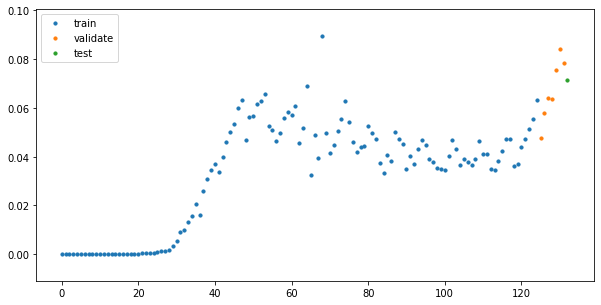

In [10]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
# ax.scatter(range(len(X)), X[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=30,color='k')
ax.scatter(range(len(X_regression_train)), X_regression_train[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=10, label='train')
ax.scatter(range(len(X_regression_train), len(X_regression_train)+len(X_regression_validate)), X_regression_validate[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=10, label='validate')
ax.scatter(range(len(X_regression_train)+len(X_regression_validate), len(X)), X_regression_test[:,np.where(data.location.unique()=='United States')[0],-1,new_cases_index], s=10, label='test')
plt.legend()
_ = plt.show()

In [11]:
# splits_3d = concatenate_4d_into_3d(scaled_splits)
# (X_regression_train_model,y_regression_train_model,X_regression_validate_model,
#  y_regression_validate_model,X_regression_test_model,y_regression_test_model) = splits_3d
X_for_naive_slicing = np.concatenate(X.reshape(X.shape[0], X.shape[1], -1), axis=0)
n_features = X.shape[-1]
last_day_new_cases_index = np.ravel_multi_index([[frame_size-1],[new_cases_index]],(frame_size, n_features))
y_train_naive = X_for_naive_slicing[train_indices, last_day_new_cases_index].ravel()
y_validate_naive =  X_for_naive_slicing[validate_indices, last_day_new_cases_index].ravel()
y_test_naive =  X_for_naive_slicing[test_indices, last_day_new_cases_index].ravel()

In [12]:
flat_splits = flatten_Xy(splits)
(X_regression_train, y_regression_train, X_regression_validate,
 y_regression_validate, X_regression_test, y_regression_test) = flat_splits

X_regression = np.concatenate((X_regression_train, X_regression_validate),axis=0)
y_regression = np.concatenate((y_regression_train, y_regression_validate),axis=0)

scorer = make_scorer(mean_squared_error, greater_is_better=False)
ridge = RidgeCV(scoring=scorer, cv=[[train_indices, validate_indices]]) 
_ = ridge.fit(X_regression, y_regression)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.72008e-25): result may not be accurate.
  overwrite_a=True).T


There were 4253 negative predictions
1-step MSE [Naive, Ridge] = [138.32170971539392,62.08428231175956]
1-step R^2 [Naive, Ridge] = [0.9171090031653221,0.962785484112958]


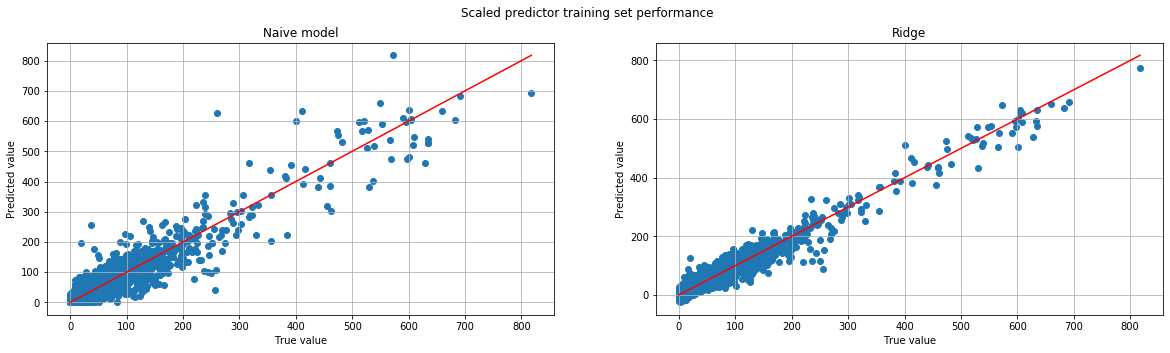

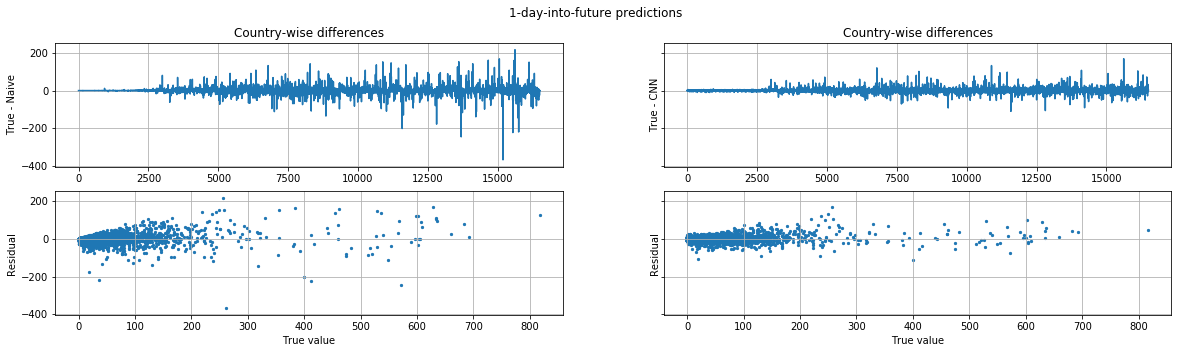

In [13]:
y_predict_train = ridge.predict(X_regression_train).ravel()
model_analysis(y_regression_train, y_train_naive, y_predict_train, n_countries, title='Ridge', suptitle='Scaled predictor training set performance')

There were 135 negative predictions
1-step MSE [Naive, Ridge] = [283.71705200108227,118.32708207896414]
1-step R^2 [Naive, Ridge] = [0.9158164771020348,0.9649185513304339]


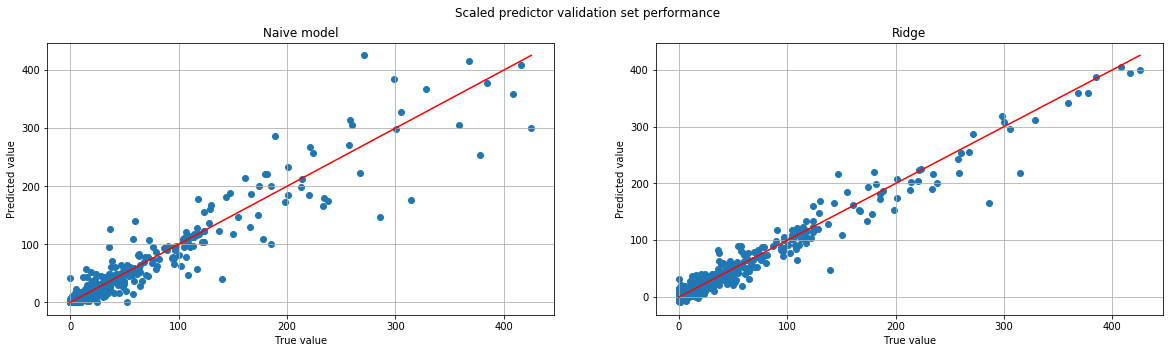

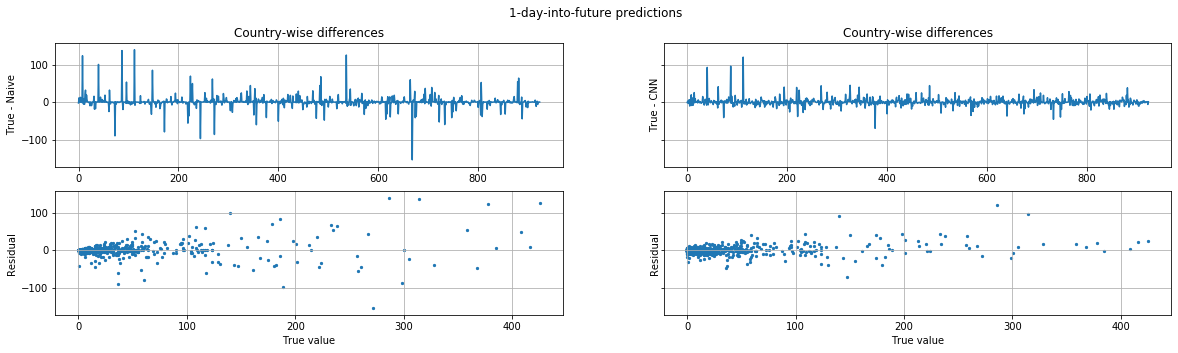

In [14]:
y_predict_validate = ridge.predict(X_regression_validate).ravel()
model_analysis(y_regression_validate, y_validate_naive, y_predict_validate, n_countries, title='Ridge', suptitle='Scaled predictor validation set performance')

In [15]:
# y_predict_test = ridge.predict(X_regression_test).ravel()
# model_analysis(y_regression_test, y_test_naive, y_predict_test, n_countries, title='Ridge', suptitle='Scaled predictor test set performance')

If concatenate is doing what I think it is, it should be sorted by time_index then country. i.e. the -n_country row is the last row of the first country, with time_steps and features contracted. this is indeed what is happening, so in the final 2d array,
the first n_countries rows corresponds to the first frame, and the columns are the features at the different time steps (a total of time steps equals ```frame_size```). s.t. X_train looks like the following

    n_countries @ frame=frame_size, frame [n_features(t=0),n_features(t=1),...,n_features(t=frame_size)]
    n_countries @ frame=frame_size+1, frame [n_features(t=1),n_features(t=2),...,n_features(t=frame_size+1)]
    n_countries @ frame=frame_size+1, frame [n_features(t=1),n_features(t=2),...,n_features(t=frame_size+1)]
    n_countries @ frame=present_date-n_days_into_future- n_test_frames  [n_features(t=1),n_features(t=2),...,n_features(t=frame_size+1)]
    
The normalization only occurs with respect to the dates inside the frame, i.e. each *row* of the final array.

In order to normalize in a consistent manner, need to find the min and max for each country and each feature up until that point in time. 

This takes the minima of each feature of each country up to current frame's end date. Need copies for each day in frame, but
only one frame value i.e.

X time index goes from 0 to max-n_days_into_future. 

first slice of X goes from 0:n_days_into_future (non-inclusive), i.e. 13. Therefore, the first prediction being made
is t=27. Therefore, the first row of y_train equals X[27,:,0,2]

X slices. start at 0, end at n_days_into_future - 1.

so X[14] corresponds to n_days_into_future - 1 + 14 = 27

X's rows correspond to the minimum time_index (starting from 0) value. so X[13] is 13,14,....26. 

question for mike, each of the shifted variables is being treated as feature, should they be normalized separately...? or normalized before the shift.

need the naive values, which are the values n_days_into_future before y_train rows. To see that this is true, look at
time_index + n_days_into_future rows. of X. i.e. first row of y is time==n_days_into_future for X.

y_train[t,c] = X[t+n_days_into_future, c, 0, 2] OR 

y_train[t,c] = X[t+1, c, -1, 2]

y_train[0, 26] = X[14,26,-1,2] = X[27,26,0,2]

I think minmaxing each frame might actually be really dumb.

# old way of modeling, single day single prediction

To compute new rolling means, take new drift feature values, concatenate with those in training, and then roll.
Need to reintroduce indexes however to sort the values correctly. 

baseline_time_series